# Vingate analysis for Credit Risk Modeling

This notebook performs vintage analysis on Lending Club loan data to evaluate credit risk over time. The analysis focuses on cohorts of loans issued in specific months and tracks their performance over subsequent months.

In [2]:
from logging import warning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

- Lending Club launch in mid 2007, there was very little data for 2007 vintage month. As peer to peer lending gained popularity, more loans were issued in 2008 and subsequent years.
- 2020 the company began its transition to a a digital bank after acquiring Radius Bank.
- 2021 Lending Club officially became a fully chartered U.S. bank, shifting its focus from peer-to-peer lending to traditional banking services.
- Today, Lending Club operates as a full service digital bank, offering a range of financial products including personal loans, savings accounts, and investment services.

In [3]:
# Load the dataset
chunk_size = 100000
chunks = pd.read_csv('accepted_2007_to_2018Q4.csv', chunksize = chunk_size, low_memory=False)
loan_df = pd.concat(chunks, ignore_index = True)
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [4]:
# Display the first few rows of the dataset
loan_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [6]:
# Check for missing values
missing_values = loan_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 member_id                                     2260701
orig_projected_additional_accrued_interest    2252050
hardship_dpd                                  2249784
hardship_status                               2249784
deferral_term                                 2249784
                                               ...   
out_prncp_inv                                      33
out_prncp                                          33
initial_list_status                                33
fico_range_high                                    33
revol_bal                                          33
Length: 150, dtype: int64


In [7]:
# Columns list
columns = loan_df.columns.tolist()
print("Dataset shape:", loan_df.shape)
print("Total number of columns:", len(columns))
print("Columns in the dataset:\n", *columns, sep=',\n')

Dataset shape: (2260701, 151)
Total number of columns: 151
Columns in the dataset:
,
id,
member_id,
loan_amnt,
funded_amnt,
funded_amnt_inv,
term,
int_rate,
installment,
grade,
sub_grade,
emp_title,
emp_length,
home_ownership,
annual_inc,
verification_status,
issue_d,
loan_status,
pymnt_plan,
url,
desc,
purpose,
title,
zip_code,
addr_state,
dti,
delinq_2yrs,
earliest_cr_line,
fico_range_low,
fico_range_high,
inq_last_6mths,
mths_since_last_delinq,
mths_since_last_record,
open_acc,
pub_rec,
revol_bal,
revol_util,
total_acc,
initial_list_status,
out_prncp,
out_prncp_inv,
total_pymnt,
total_pymnt_inv,
total_rec_prncp,
total_rec_int,
total_rec_late_fee,
recoveries,
collection_recovery_fee,
last_pymnt_d,
last_pymnt_amnt,
next_pymnt_d,
last_credit_pull_d,
last_fico_range_high,
last_fico_range_low,
collections_12_mths_ex_med,
mths_since_last_major_derog,
policy_code,
application_type,
annual_inc_joint,
dti_joint,
verification_status_joint,
acc_now_delinq,
tot_coll_amt,
tot_cur_bal,
open_acc_6

In [21]:
# Vintage analysis dataframe, selecting relevant columns
vintage_df = loan_df[['id', 'loan_amnt', 'term', 'issue_d', 'last_pymnt_d', 'loan_status']].copy()
print("Vintage DataFrame created with shape:", vintage_df.shape)

Vintage DataFrame created with shape: (2260701, 6)


In [22]:
# Feature engineering
# Drop rows with missing values in critical columns
vintage_df['issue_d'] = pd.to_datetime(vintage_df['issue_d'], errors='coerce', format='%b-%Y') # format='%b-%Y'
vintage_df['vintage_month'] = vintage_df['issue_d'].dt.to_period('M')
vintage_df['last_pymnt_d'] = pd.to_datetime(vintage_df['last_pymnt_d'], errors='coerce', format='%b-%Y') # format='%b-%Y'
print
vintage_df.head()


,id,loan_amnt,term,issue_d,last_pymnt_d,loan_status,vintage_month
0,68407277,3600.0,36 months,2015-12-01,2019-01-01,Fully Paid,2015-12
1,68355089,24700.0,36 months,2015-12-01,2016-06-01,Fully Paid,2015-12
2,68341763,20000.0,60 months,2015-12-01,2017-06-01,Fully Paid,2015-12
3,66310712,35000.0,60 months,2015-12-01,2019-02-01,Current,2015-12
4,68476807,10400.0,60 months,2015-12-01,2016-07-01,Fully Paid,2015-12


In [23]:
# Check for missing values
missing_values = vintage_df.isnull().sum()
print(missing_values[missing_values > 0])

loan_amnt          33
term               33
issue_d            33
last_pymnt_d     2460
loan_status        33
vintage_month      33
dtype: int64


In [24]:
# Drop rows with missing values in critical columns
vintage_df.dropna(subset=['loan_amnt', 'term', 'issue_d', 'loan_status'], inplace=True)
print("Missing values after cleaning:\n", vintage_df.isnull().sum())

Missing values after cleaning:
 id                  0
loan_amnt           0
term                0
issue_d             0
last_pymnt_d     2427
loan_status         0
vintage_month       0
dtype: int64


In [25]:
# Value counts of loan_status
print(vintage_df['loan_status'].value_counts(dropna=False))

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64


In [26]:
# Last payment date missing analysis
vintage_df[vintage_df['last_pymnt_d'].isnull()]['loan_status'].value_counts()

loan_status
Charged Off                                            2313
Late (31-120 days)                                      102
Does not meet the credit policy. Status:Charged Off      12
Name: count, dtype: int64

In [27]:
# Max min issue date and last payment date
print("Issue Date Range:", vintage_df['issue_d'].min(), "to", vintage_df['issue_d'].max())
print("Last Payment Date Range:", vintage_df['last_pymnt_d'].min(), "to", vintage_df['last_pymnt_d'].max())
# Last payment in dataset = portfolio snapshot date
portfolio_snapshot_date = vintage_df['last_pymnt_d'].max()
print("Portfolio Snapshot Date:", portfolio_snapshot_date)

Issue Date Range: 2007-06-01 00:00:00 to 2018-12-01 00:00:00
Last Payment Date Range: 2007-12-01 00:00:00 to 2019-03-01 00:00:00
Portfolio Snapshot Date: 2019-03-01 00:00:00


In [28]:
# Fill missing last payment dates with portfolio snapshot date
vintage_df['last_pymnt_d'].fillna(portfolio_snapshot_date, inplace=True)

In [29]:
# compute months difference using Periods
months = (vintage_df['last_pymnt_d'].dt.year - vintage_df['issue_d'].dt.year) * 12 + (vintage_df['last_pymnt_d'].dt.month - vintage_df['issue_d'].dt.month)
vintage_df['months_since_issue'] = months.astype('Int64')
vintage_df['term'] = vintage_df['term'].str.extract('(\d+)').astype(int)
print("Vintage dataframe created.")

Vintage dataframe created.


In [31]:
# Drop loan statuses that does not meet policy loan statuses
valid_statuses = ['Fully Paid', 'Current', 'In Grace Period', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default']
vintage_df = vintage_df[vintage_df['loan_status'].isin(valid_statuses)]
print("After filtering, vintage dataframe shape:", vintage_df.shape)
vintage_df['loan_status'].value_counts()

After filtering, vintage dataframe shape: (2257919, 8)


loan_status
Fully Paid            1076751
Current                878317
Charged Off            268559
Late (31-120 days)      21467
In Grace Period          8436
Late (16-30 days)        4349
Default                    40
Name: count, dtype: int64

In [32]:
# Ceate deafult_flag column
# Define perfromance flag (default/charge-off)
defult_statuses = ['Charged Off', 'Default']
vintage_df['default_flag'] = vintage_df['loan_status'].apply(lambda x: 1 if x in defult_statuses else 0)

In [60]:
# Build the core vintage analysis table
vintage_analysis = vintage_df.pivot_table(
    index='vintage_month',
    columns='months_since_issue',
    values='default_flag',
    aggfunc='mean'
).sort_index()
vintage_analysis = vintage_analysis.cumsum(axis=1)
print("Vintage analysis table created with shape:", vintage_analysis.shape)
print(vintage_analysis.head())

Vintage analysis table created with shape: (139, 114)
months_since_issue  0    1    2    3    4    5    6         7         8    \
vintage_month                                                               
2007-06             NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN   
2007-07             NaN  NaN  NaN  NaN  NaN  NaN  0.0       NaN       NaN   
2007-08             NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.333333  0.333333   
2007-09             NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.000000       NaN   
2007-10             NaN  NaN  NaN  0.0  NaN  NaN  0.0  0.666667  1.666667   

months_since_issue       9    ...  109  110  111  112  113  114  116  117  \
vintage_month                 ...                                           
2007-06                  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2007-07             0.000000  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2007-08             0.333333  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2007-09              

In [ ]:
# Vintage analysis for 2018
# Limit to first 12 months in last 12 months
vintage_analysis_2018 = vintage_analysis.tail(12) # vintage_analysis.loc['2018-01':'2018-12']
vintage_analysis_2018.dropna(axis=1, how='all', inplace=True)
vintage_analysis_2018

months_since_issue,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
vintage_month,,,,,,,,,,,,,,,
2018-01,0.003876,0.102941,0.301385,0.546127,0.838896,1.140309,1.446995,1.756013,2.022382,2.325292,2.428838,2.473831,2.495676,2.498051,2.500063
2018-02,0.000000,0.107078,0.346016,0.589203,0.849477,1.169120,1.488544,1.798636,2.096571,2.187771,2.216548,2.253585,2.255849,2.257895,NaN
2018-03,0.000000,0.123288,0.409292,0.662367,0.933068,1.253849,1.583201,1.901672,2.011591,2.048160,2.073447,2.078002,2.080206,NaN,NaN
2018-04,0.004098,0.117811,0.360348,0.669009,1.015695,1.365619,1.700677,1.814457,1.857426,1.880864,1.884201,1.886322,NaN,NaN,NaN
2018-05,0.003509,0.120887,0.402137,0.689846,1.030665,1.366994,1.496575,1.537620,1.561136,1.563673,1.565715,NaN,NaN,NaN,NaN
2018-06,0.004098,0.123279,0.395037,0.713878,1.050768,1.172573,1.213843,1.239421,1.244960,1.246432,NaN,NaN,NaN,NaN,NaN
2018-07,0.004505,0.130750,0.402489,0.695536,0.797342,0.818980,0.844497,0.845883,0.847263,NaN,NaN,NaN,NaN,NaN,NaN
2018-08,0.008511,0.128033,0.405116,0.471318,0.493655,0.516673,0.518069,0.519238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09,0.006098,0.164325,0.215420,0.248439,0.262862,0.263631,0.265091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The table shows the cumulative default rates for loans issued in each month of 2018, tracked over the first 12 months since issuance. 

For example, loans issued in January 2018 had a cumulative default rate of approximately 2.5% after 12 months. This indicates that 2.5% of the loans issued in January 2018 had defaulted within their first year. Similarly, loans issued in February 2018 had a cumulative default rate of about 2.26% after 11 months.

The data cut off is March 2019, so loans issued in December 2018 have three months of performance data available, showing a cumulative default rate of approximately 1.37% after three months.

The vintage analysis provides insights into how default rates evolve over time for different cohorts of loans, which is valuable for credit risk modeling and understading loan performance trends.

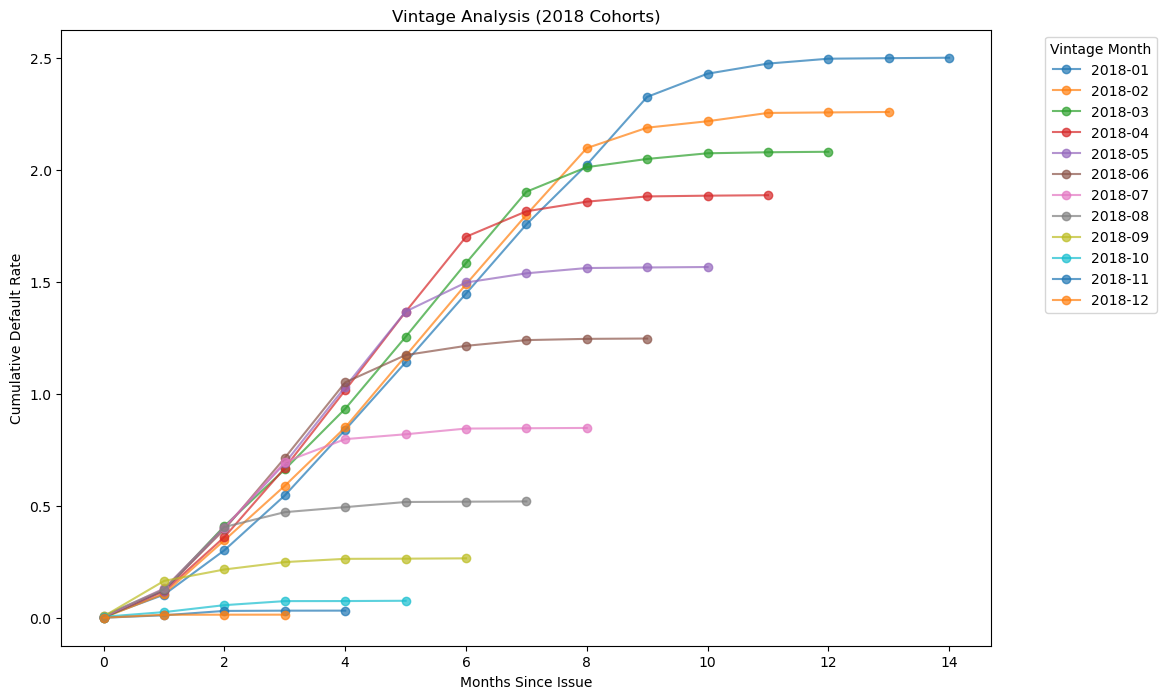

In [99]:
# Plotting the vintage analysis
plt.figure(figsize=(12, 8))
for i in vintage_analysis_2018.index:
    plt.plot(vintage_analysis_2018.columns, vintage_analysis_2018.loc[i], marker='o', alpha=0.7)
plt.legend(vintage_analysis_2018.index.astype(str), title='Vintage Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Vintage Analysis (2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Cumulative Default Rate')
plt.show()

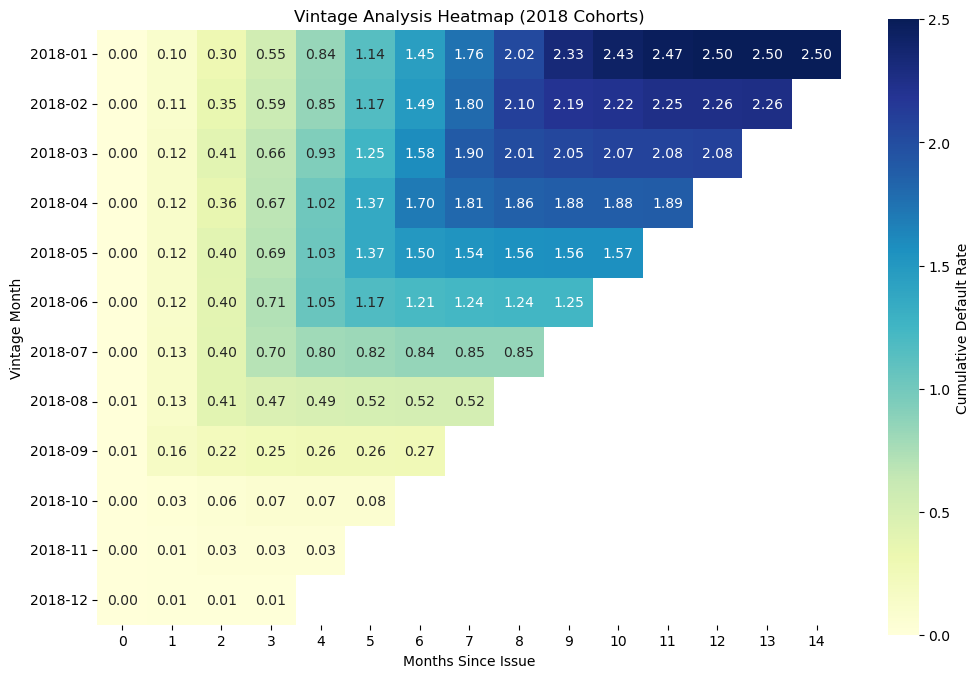

In [95]:
# Plotting the vintage analysis heatmap for 2018
plt.figure(figsize=(12, 8))
sns.heatmap(vintage_analysis_2018, square=True, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Cumulative Default Rate'})
plt.title('Vintage Analysis Heatmap (2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Vintage Month')
plt.show()

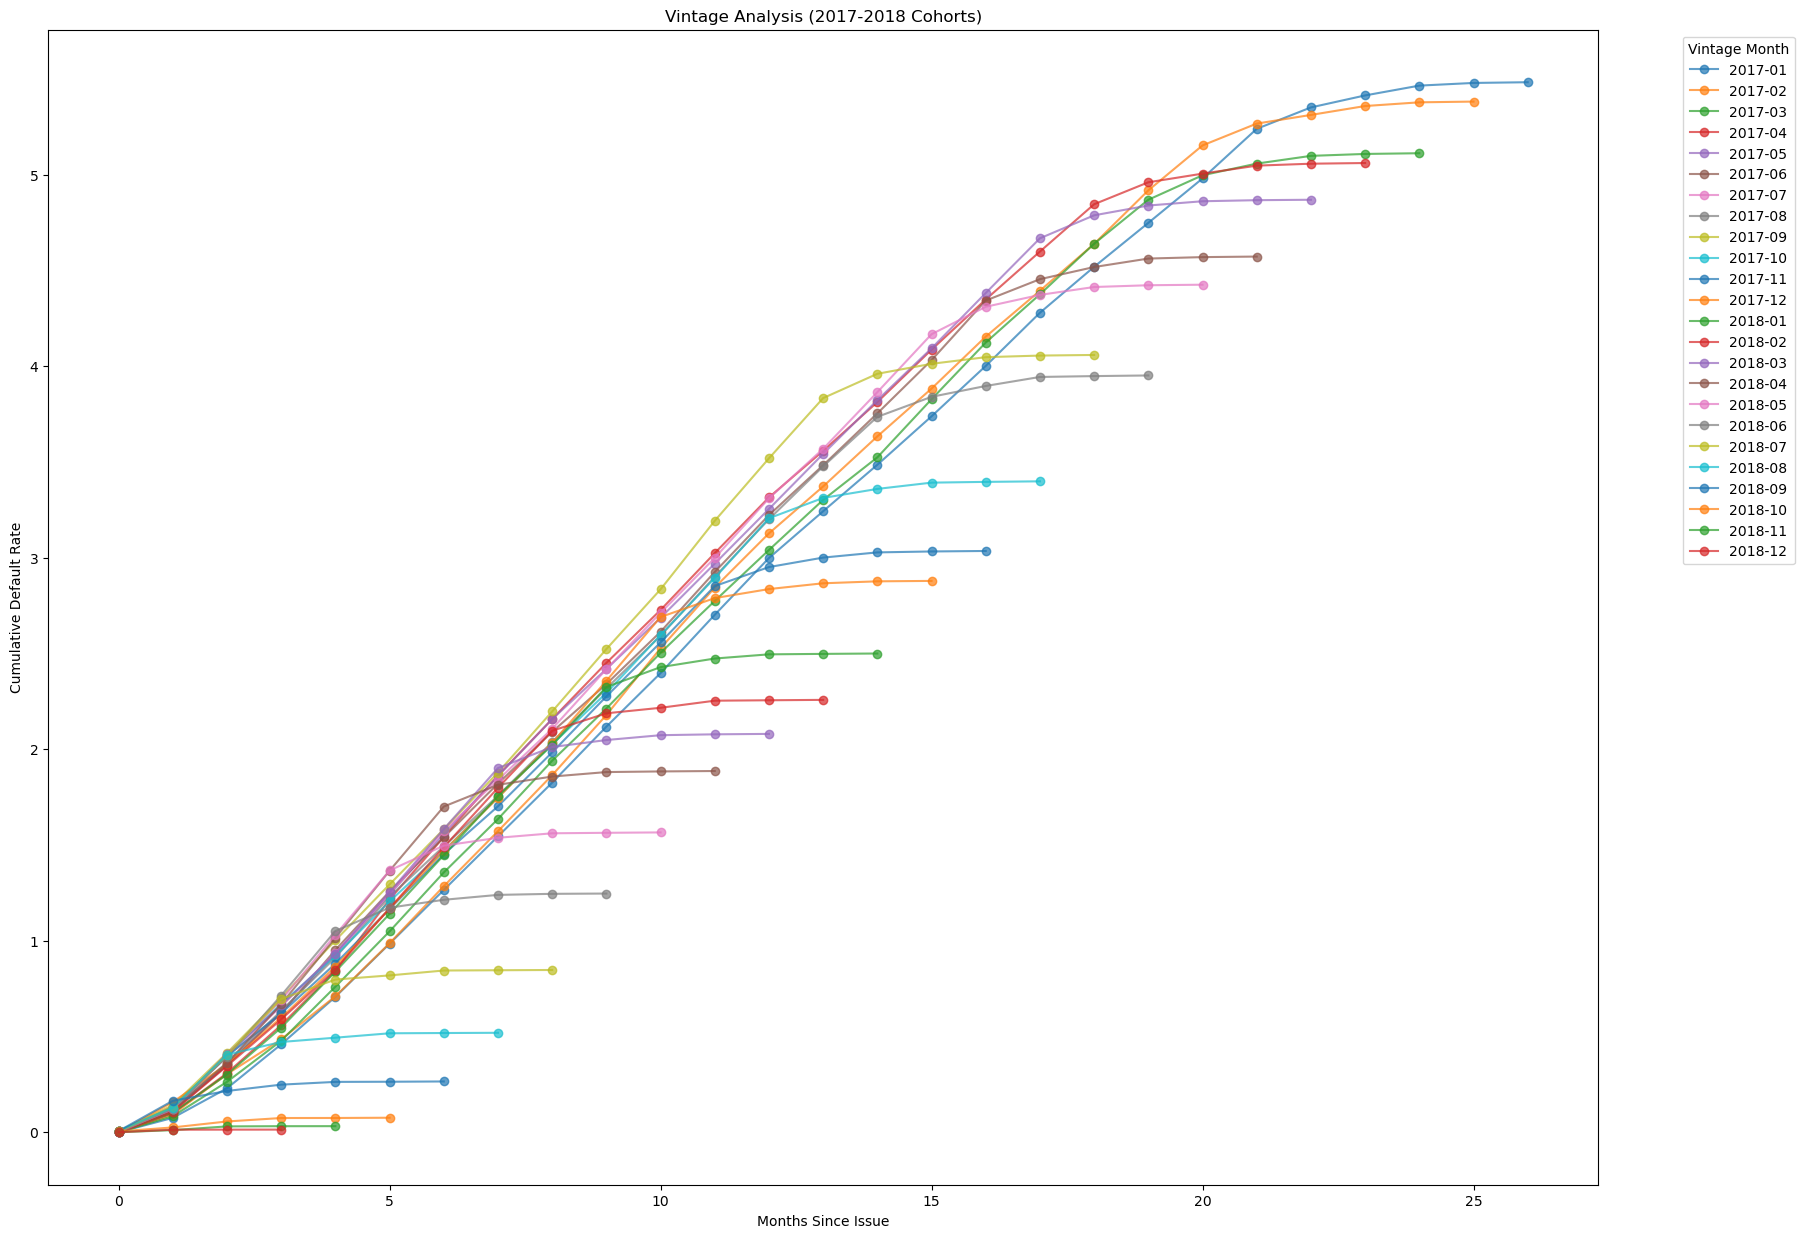

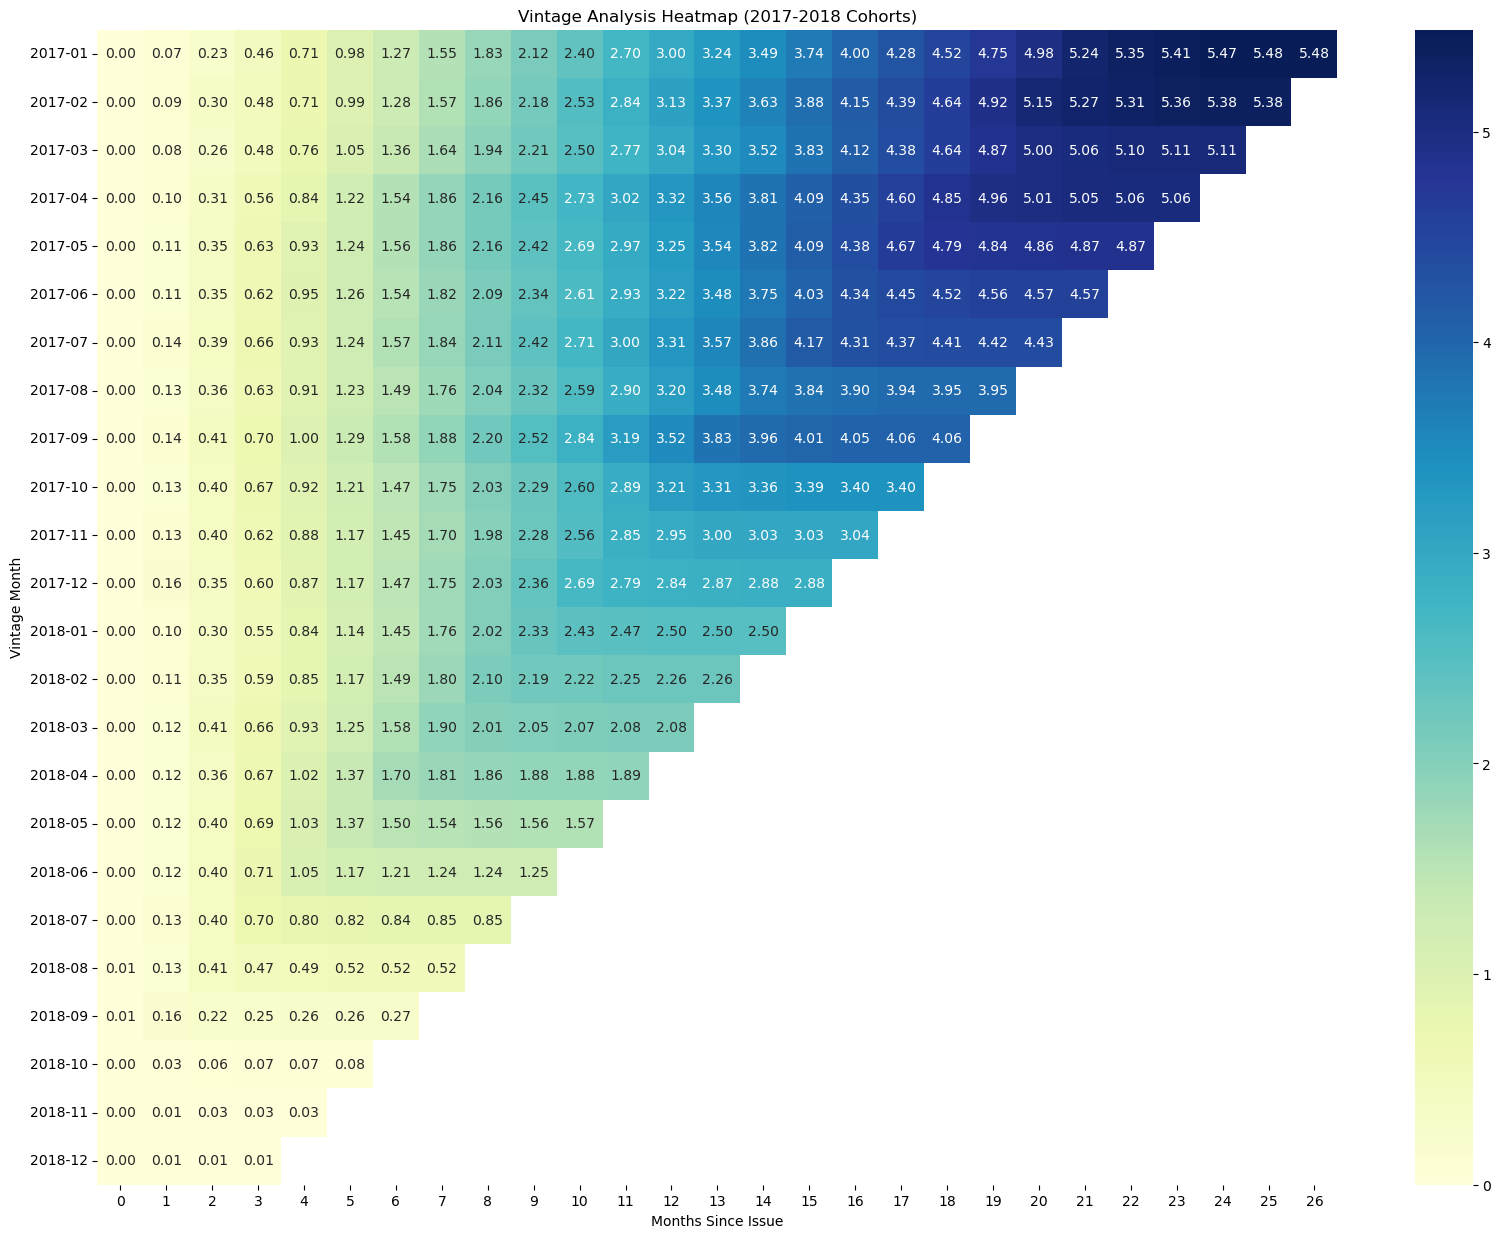

In [109]:
# Vintage analysis for 2017-2018
vintage_analysis_2017_2018 = vintage_analysis.loc['2017-01':'2018-12']
vintage_analysis_2017_2018.dropna(axis=1, how='all', inplace=True)
vintage_analysis_2017_2018
# Plotting the vintage analysis for 2017-2018
plt.figure(figsize=(20, 15))
for i in vintage_analysis_2017_2018.index:
    plt.plot(vintage_analysis_2017_2018.columns, vintage_analysis_2017_2018.loc[i], marker='o', alpha=0.7)
plt.legend(vintage_analysis_2017_2018.index.astype(str), title='Vintage Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Vintage Analysis (2017-2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Cumulative Default Rate')
plt.show()
# Plotting the vintage analysis heatmap for 2017-2018
plt.figure(figsize=(20, 15))
sns.heatmap(vintage_analysis_2017_2018, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Vintage Analysis Heatmap (2017-2018 Cohorts)')
plt.xlabel('Months Since Issue')
plt.ylabel('Vintage Month')
plt.show()

In [113]:
#Add cumulative default rates by year
vintage_cum_yearly = vintage_analysis.resample('Y').last()
vintage_cum_yearly.index = vintage_cum_yearly.index.year
# Average cumulative default rates by year
vintage_cum_yearly.groupby(vintage_cum_yearly.index).mean()
# look at first 12 months of each year
vintage_cum_yearly_first12 = vintage_analysis.groupby(vintage_analysis.index.year).apply(lambda x: x.loc[:, 0:12].mean())
vintage_cum_yearly_first12

months_since_issue,0,1,2,3,4,5,6,7,8,9,10,11,12
vintage_month,,,,,,,,,,,,,
2007,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.400000,1.000000,0.416667,1.666667,1.375000,1.000000
2008,NaN,0.250000,0.321429,0.854167,0.817708,1.038542,1.489167,1.757292,2.028030,2.738542,2.925000,3.293519,3.726323
2009,NaN,0.207071,0.474387,0.902216,1.331283,1.806680,1.976846,2.448683,2.759235,3.082614,3.456791,3.783210,4.006325
2010,NaN,0.167460,0.374946,0.718735,1.048820,1.420513,1.719413,2.040522,2.346442,2.627675,2.893231,3.195516,3.469778
2011,NaN,0.126604,0.397863,0.753233,1.126282,1.494480,1.883728,2.214422,2.514420,2.811464,3.147458,3.443804,3.743083
2012,0.000000,0.157457,0.477604,0.799840,1.206205,1.590837,1.969172,2.328651,2.681638,3.014190,3.354045,3.706413,4.017677
2013,0.000000,0.131722,0.357572,0.638113,0.932358,1.240408,1.531116,1.841798,2.120825,2.405837,2.679471,2.972022,3.245025
2014,0.000000,0.117019,0.337512,0.599977,0.884786,1.177240,1.477869,1.765210,2.016673,2.295437,2.579413,2.877798,3.147142
2015,0.000859,0.118229,0.338602,0.620720,0.921078,1.250500,1.584420,1.930538,2.276432,2.625594,2.983434,3.326695,3.667322


From 2007 to 2011, there have NaN values in month 0 and month 2 for 2007 vintage month, and month 0 from 2008 to 2011 vintage months. This is because Lending Club launched in mid-2007, so there were very few loans issued in 2007, and early data collection may have been inconsistent, very few loans issued in those initial months, leading to insufficient data to calculate default rates for those periods.

So we will focus on vintage months from 2012 onwards for more reliable analysis.

In [117]:
# From 2007 to 2011, there have NaN values in month 0 and month 2 for 2007 vintage month, and month 0 from 2008 to 2011 vintage months. 
vintage_cum_yearly_first12_from_2012 = vintage_cum_yearly_first12.loc[2012:]
vintage_cum_yearly_first12_from_2012

months_since_issue,0,1,2,3,4,5,6,7,8,9,10,11,12
vintage_month,,,,,,,,,,,,,
2012,0.000000,0.157457,0.477604,0.799840,1.206205,1.590837,1.969172,2.328651,2.681638,3.014190,3.354045,3.706413,4.017677
2013,0.000000,0.131722,0.357572,0.638113,0.932358,1.240408,1.531116,1.841798,2.120825,2.405837,2.679471,2.972022,3.245025
2014,0.000000,0.117019,0.337512,0.599977,0.884786,1.177240,1.477869,1.765210,2.016673,2.295437,2.579413,2.877798,3.147142
2015,0.000859,0.118229,0.338602,0.620720,0.921078,1.250500,1.584420,1.930538,2.276432,2.625594,2.983434,3.326695,3.667322
2016,0.001068,0.116406,0.350968,0.638730,0.947631,1.274063,1.622458,1.963361,2.301671,2.647252,2.983853,3.311379,3.634092
2017,0.000767,0.115755,0.344388,0.592667,0.868244,1.170192,1.465509,1.747469,2.035138,2.325449,2.620158,2.905887,3.165431
2018,0.003247,0.097300,0.278112,0.450421,0.670772,0.914342,1.173055,1.426618,1.663047,1.875365,2.033750,2.172935,2.277243


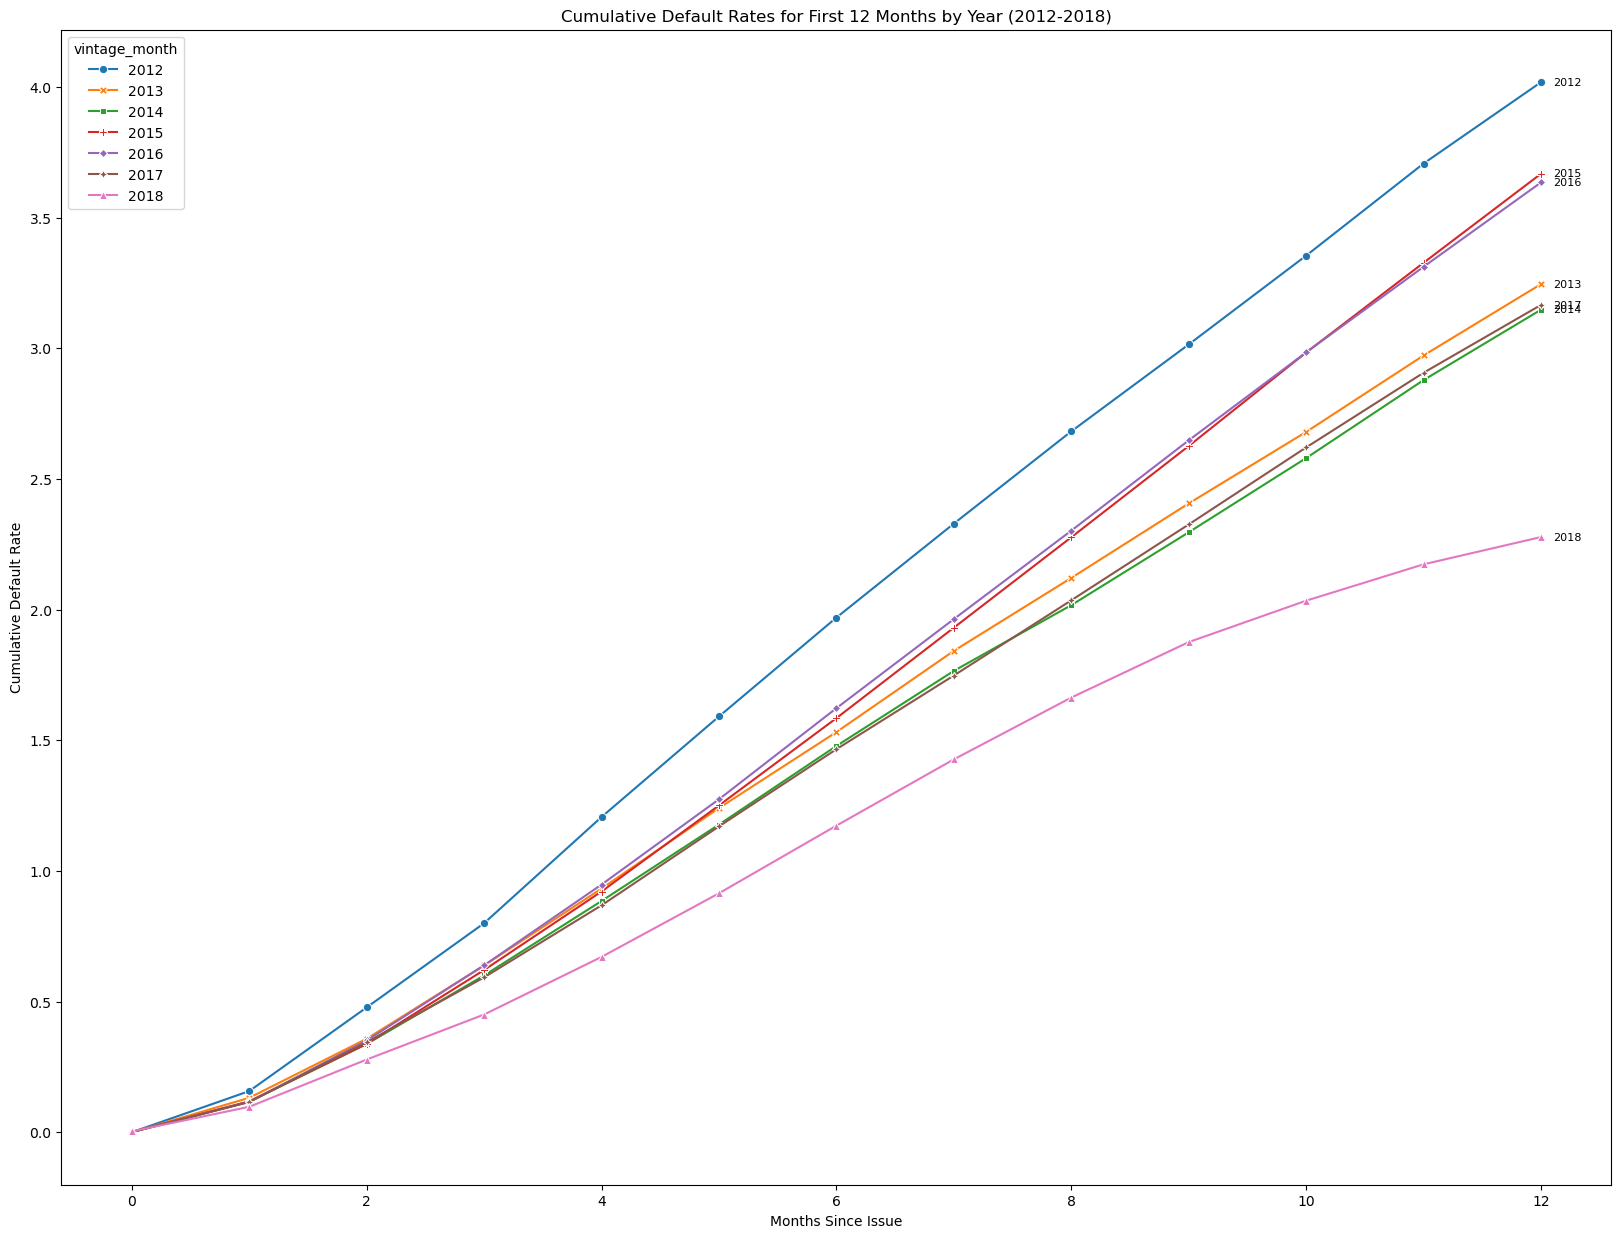

In [126]:
# Plotting the cumulative default rates for first 12 months by year from 2012
plt.figure(figsize=(20, 15))
sns.lineplot(data=vintage_cum_yearly_first12_from_2012.T, markers=True, dashes=False)
# Text notation at each line end year index
for year in vintage_cum_yearly_first12_from_2012.index:
    plt.text(12.1, vintage_cum_yearly_first12_from_2012.loc[year, 12], str(year), fontsize=8, verticalalignment='center')
plt.title('Cumulative Default Rates for First 12 Months by Year (2012-2018)')
plt.xlabel('Months Since Issue')
plt.ylabel('Cumulative Default Rate')
plt.show()

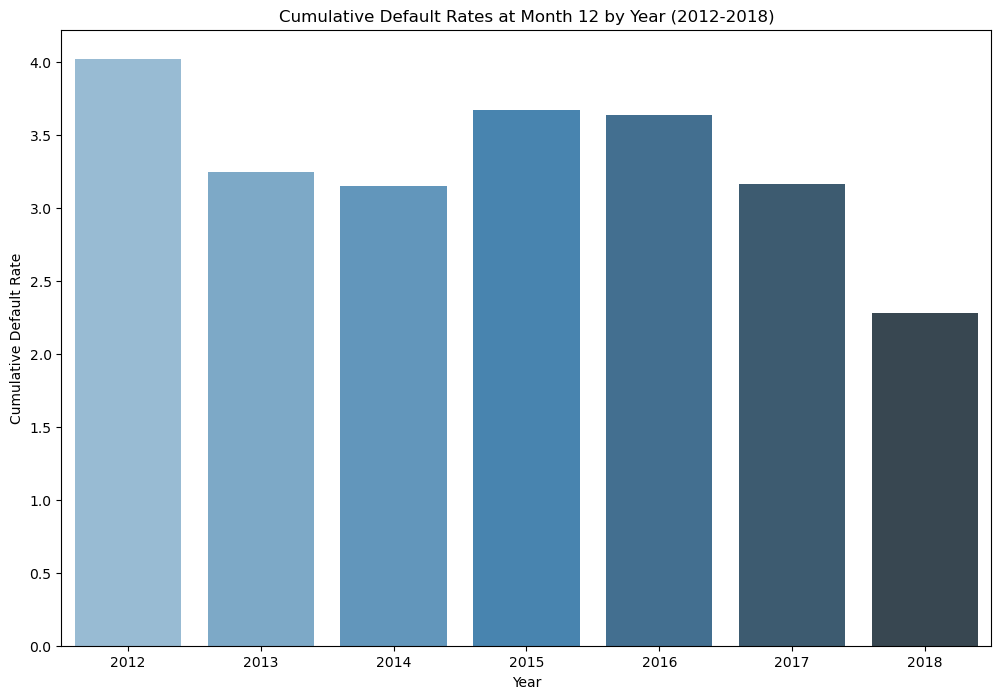

In [147]:
# Plot in month 12 cumulative default rates from 2012 onwards
plt.figure(figsize=(12, 8))
sns.barplot(x=vintage_cum_yearly_first12_from_2012.index, y=vintage_cum_yearly_first12_from_2012[12], palette="Blues_d")
plt.title('Cumulative Default Rates at Month 12 by Year (2012-2018)')
plt.xlabel('Year')
plt.ylabel('Cumulative Default Rate')
plt.show()

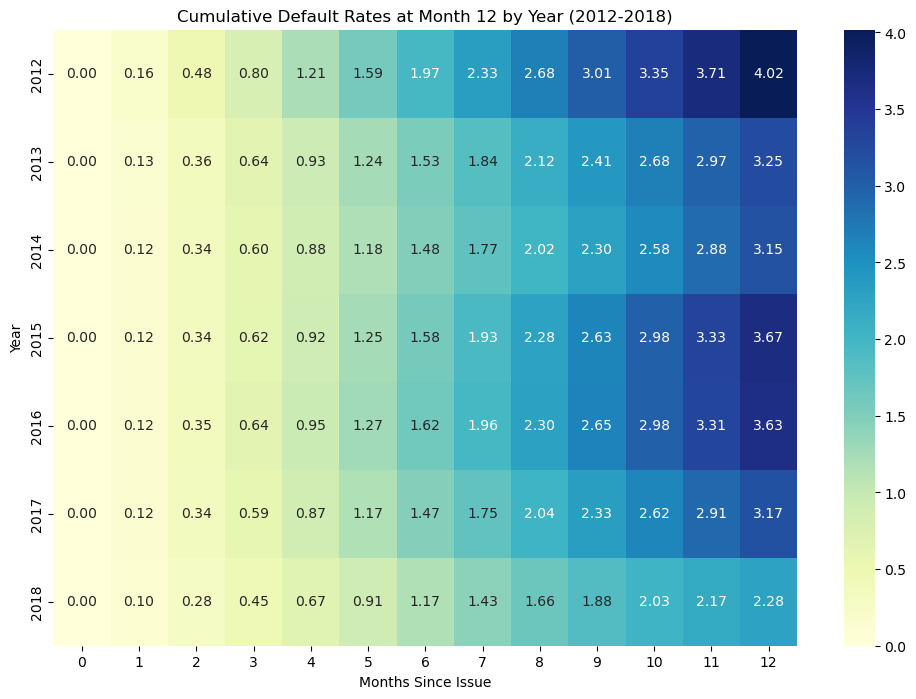

In [148]:
# Heatmap of 12 months cumulative default rates from 2012 onwards
plt.figure(figsize=(12, 8))
sns.heatmap(vintage_cum_yearly_first12_from_2012, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Cumulative Default Rates at Month 12 by Year (2012-2018)')
plt.xlabel('Months Since Issue')
plt.ylabel('Year')
plt.show()


- The vintage analysis provides insights into how default rates evolve over time for different cohorts of loans, which is valuable for credit risk modeling and understading loan performance trends.
- From 2011 to 2018, the cumulative default rates for loans issued in each month show a general trend of decreasing default rates. This indicates that Lending Club's loan portfolio has improved in quality over time, likely due to better underwriting practices, risk assessment.
- In 2018, the cumulative default rates are significantly lower compared to previous years. For example, loans issued in 2012 had a cumulative default rate of about 4.02% after 12 months, while loans issued in 2018 had a cumulative default rate of approximately 2.28% after the same period. This suggests that Lending Club has been successful in reducing credit risk in its loan portfolio over the years.
- 2012 was the worst year for lending club loans
- 2012 - 2014 were strong improvement years
- 2015 -2016 deterioration years
- 2017 was recovery year
- 2018 was the best performing year (lowest default rates across 12 months)

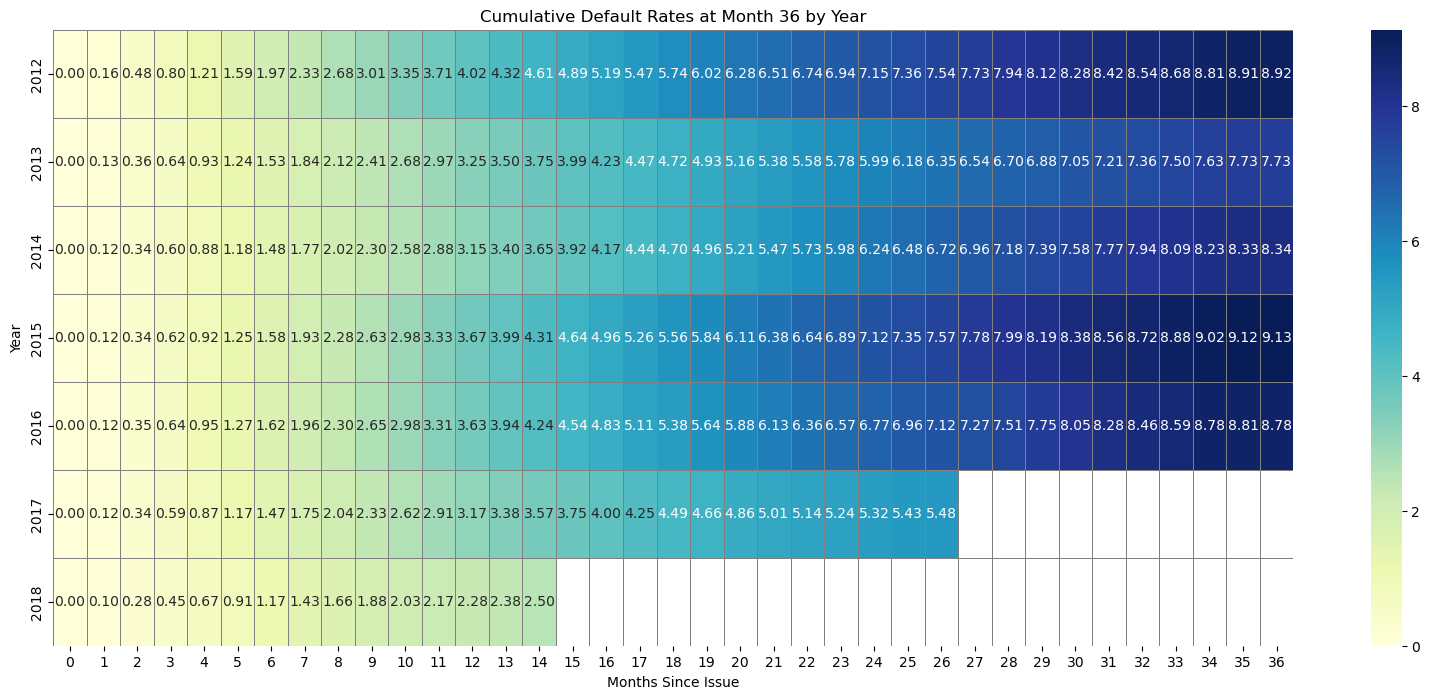

In [145]:
# month-36 and 60 of each year
vintage_cum_yearly_36 = vintage_analysis.groupby(vintage_analysis.index.year).apply(lambda x: x.loc[:, :36].mean())
vintage_cum_yearly_36_from_2012 = vintage_cum_yearly_36.loc[2012:]
# Heatmap of 36 months cumulative default rates from 2012 onwards
plt.figure(figsize=(20, 8))
sns.heatmap(vintage_cum_yearly_36_from_2012, annot=True, fmt=".2f", cmap="YlGnBu",linewidths=0.5, linecolor='gray')
plt.title('Cumulative Default Rates at Month 36 by Year')
plt.xlabel('Months Since Issue')
plt.ylabel('Year')
plt.show()

The heatmap visualizes the cumulative default rates at month 36 for loans issued from 2012 onwards.
- Early moths (0-6) show lower default rates, 2015 and 2016 show slightly faster early default rates compared to other years.
- Mid-term months (6-12), 2012 has the highest default rates, followed by 2015, 2016, and 2013.
- Long-term months (12-36), 2012 consistently shows the highest default rates, indicating that loans issued in this year had poorer performance over the long term. followed by 2015, 2016, and 2013.